# Notebook to get the figures of the experiments on the hyperbolic manifold
Greatly nspired by https://github.com/clbonet/Hyperbolic_Sliced-Wasserstein_via_Geodesic_and_Horospherical_Projections



In [ ]:
import torch
import math

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.auto import trange
from mpl_toolkits import mplot3d
from scipy.stats import gaussian_kde
from typing import Any, Tuple, Optional
from torch import Tensor
from copy import deepcopy

#import sys
#sys.path.append('./lib_hyp')

from lib_hyp.utils_hyperbolic import *
from lib_hyp.distributions import sampleWrappedNormal
from lib_hyp.hsw import hyper_sliced_wasserstein
from lib_hyp.hhsw import horo_hyper_sliced_wasserstein_poincare, horo_hyper_sliced_wasserstein_lorentz
from lib_hyp.sw import sliced_wasserstein

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Utils Plot

In [28]:
## From https://colab.research.google.com/drive/1kSdmi2r6QMO7gI8YPqeiWoW2ayxcu1MY?usp=sharing#scrollTo=LFl3I-ycM0vJ

eps = 1e-7
max_clamp_norm = 40
max_norm = 85
ln_2: torch.Tensor = math.log(2)

radius = torch.Tensor([1.0]).to(device)


def expand_proj_dims(x: torch.Tensor) -> torch.Tensor:
    zeros = torch.zeros(x.shape[:-1] + torch.Size([1])).to(x.device).to(x.dtype)
    return torch.cat((zeros, x), dim=-1)

# We will use this clamping technique to ensure numerical stability of the Exp and Log maps
class LeakyClamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx: Any, x: torch.Tensor, min: float, max: float) -> torch.Tensor:
        ctx.save_for_backward(x.ge(min) * x.le(max))
        return torch.clamp(x, min=min, max=max)

    @staticmethod
    def backward(ctx: Any, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None, None]:
        mask, = ctx.saved_tensors
        mask = mask.type_as(grad_output)
        return grad_output * mask + grad_output * (1 - mask) * eps, None, None

def clamp(x: torch.Tensor, min: float = float("-inf"), max: float = float("+inf")) -> torch.Tensor:
    return LeakyClamp.apply(x, min, max)

def cosh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.cosh(x)

def sinh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.sinh(x)

# Exp map for the origin has a special form which doesn't need the Lorentz norm
def exp_map_mu0(x: Tensor, radius: Tensor) -> Tensor:
    assert x[..., 0].allclose(torch.zeros_like(x[..., 0]))
    x = x[..., 1:]
    x_norm = torch.norm(x, p=2, keepdim=True, dim=-1) / radius
    x_normed = F.normalize(x, p=2, dim=-1) * radius
    ret = torch.cat((cosh(x_norm) * radius, sinh(x_norm) * x_normed), dim=-1)
    assert torch.isfinite(ret).all()
    return ret

# Helper function to do the plotting
def plot_density(xy_poincare, probs, radius, mu=None, ax=None):
    axis_lim = 1.01
    
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)

    x = xy_poincare[:, 0].view(-1, 100).detach().cpu()
    y = xy_poincare[:, 1].view(-1, 100).detach().cpu()
    z = probs.view(-1, 100).detach().cpu()
    range_lim = 2
    # Define points within circle
    if mu is not None:
        mu = mu.cpu().numpy()
        plt.plot(mu[:, 0], mu[:, 1], 'b+')

    cnt = ax.contourf(x, y, z, 100, antialiased=False, cmap='Oranges')
    
    ## Remove aliasing from pdf rendering (https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps)
    for c in cnt.collections:
        c.set_edgecolor("face")
    ax.axis('off')

    # draw some fancy circle
    circle = plt.Circle((0, 0), 1, color='k', linewidth=2, fill=False)
    ax.add_patch(circle)
    # Makes the circle look like a circle
    ax.axis('equal')
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)

In [29]:
def plot_distrib(X, ax, h=None):
    kernel = gaussian_kde(X.detach().cpu().numpy().T)
    
    if h is not None:
        kernel.set_bandwidth(h)

    # Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    x, y = np.meshgrid(x, y)
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    twodim = torch.cat([x, y], dim=1)
    threedim = expand_proj_dims(twodim)
    clamped_threedim = clamp(threedim, min=-max_clamp_norm,
          max=max_clamp_norm).to(device)

    on_mani = exp_map_mu0(clamped_threedim, radius)
    probs = torch.tensor(kernel.pdf(on_mani.T.detach().cpu().numpy()))
    # Calculate the poincare coordinates
    xy_poincare = lorentz_to_poincare(on_mani.squeeze(), radius)
    plot_density(xy_poincare, probs, radius,ax=ax)

In [ ]:

def plot_fig(X_target, L_hhsw, L_swp, L_swgg_hyp, ax0, ax1, type="center", h=None):
    #compares only with Poincare space  
    L_hhsw10 = np.log10(L_hhsw)
    L_swp10 = np.log10(L_swp)
    L_swgg_hyp10 = np.log10(L_swgg_hyp)

    mean_hhsw = np.mean(L_hhsw10, axis=0)
    std_hhsw = np.std(L_hhsw10, axis=0)

    mean_swp = np.mean(L_swp10, axis=0)
    std_swp = np.std(L_swp10, axis=0)

    mean_swgg_hyp = np.mean(L_swgg_hyp10, axis=0)
    std_swgg_hyp = np.std(L_swgg_hyp10, axis=0)

    n_epochs = len(mean_hhsw)
    iterations = range(n_epochs)


    plot_distrib(X_target, ax0, h)

    ax1.plot(iterations, mean_hhsw, label="HHSW")
    ax1.fill_between(iterations, mean_hhsw-std_hhsw, mean_hhsw+std_hhsw, alpha=0.5)
    ax1.plot(iterations, mean_swp, label="SW")
    ax1.fill_between(iterations, mean_swp-std_swp, mean_swp+std_swp, alpha=0.5)
    #ax1.plot(iterations, mean_swgg_euc, label="E-DGWSP")
    #ax1.fill_between(iterations, mean_swgg_euc-std_swgg_euc, mean_swgg_euc+std_swgg_euc, alpha=0.5)
    ax1.plot(iterations, mean_swgg_hyp, label="DSWP")
    ax1.fill_between(iterations, mean_swgg_hyp-std_swgg_hyp, mean_swgg_hyp+std_swgg_hyp, alpha=0.5)

    ax1.set_xlabel("Iterations", fontsize=13)
    ax1.set_ylabel(r"$\log_{10}(W_2^2(\hat{\mu}_n,\nu))$", fontsize=13)
    ax1.grid(True)
    ax1.legend()

    plt.savefig("./Comparison_Evolution_WND_Target_"+type+".pdf", format="pdf", bbox_inches="tight")
    plt.show()

### Expe1: WND Center

In [31]:
mu = torch.tensor([1.5, np.sqrt(1.5**2-1), 0], dtype=torch.float64, device=device)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_target_wnd_c = sampleWrappedNormal(mu, Sigma, 10000)

In [43]:

L_hhsw_wnd_c = np.loadtxt("./Results/hhsw_loss_wnd_center")
L_swp_wnd_c = np.loadtxt("./Results/swp_loss_wnd_center")
L_swgg_wnd_c = np.loadtxt("./Results/swgg_hyp_loss_wnd_center")


/var/folders/93/kzdc_fld6lzf2wdsrdy7ys980000gp/T/ipykernel_1011/3494724148.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


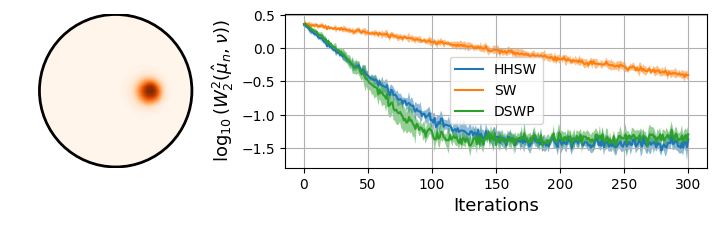

In [ ]:
import matplotlib.font_manager
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": "cm"
#})
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_fig(X_target_wnd_c, L_hhsw_wnd_c, L_swp_wnd_c, L_swgg_wnd_c, ax[0], ax[1], "center")
plt.show()

### Expe2: WND Border

In [17]:
mu = torch.tensor([8, np.sqrt(63), 0], dtype=torch.float64, device=device)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_target_wnd_b = sampleWrappedNormal(mu, Sigma, 10000)

In [47]:

L_hhsw_wnd_b = np.loadtxt("./Results/hhsw_loss_wnd_border")
L_swp_wnd_b = np.loadtxt("./Results/swp_loss_wnd_border")
L_swgg_wnd_b = np.loadtxt("./Results/swgg_hyp_loss_wnd_border")

/var/folders/93/kzdc_fld6lzf2wdsrdy7ys980000gp/T/ipykernel_1011/3494724148.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


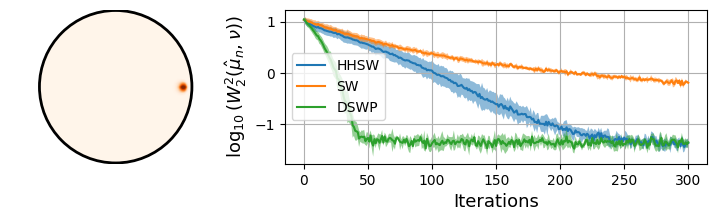

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})
plot_fig(X_target_wnd_b, L_hhsw_wnd_b, L_swp_wnd_b, L_swgg_wnd_b, ax[0], ax[1], "border")